# Mounting the Gdrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Cloning DepthModel from Git

In [0]:
!git clone https://github.com/gudaykiran/DepthModel 

Cloning into 'DepthModel'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 244 (delta 125), reused 232 (delta 119), pack-reused 0
Receiving objects: 100% (244/244), 11.79 MiB | 43.43 MiB/s, done.
Resolving deltas: 100% (125/125), done.


# Getting nyu.h5 model from Depth Model

In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DepthModel/nyu.h5

--2020-05-09 22:09:08--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.37.10
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.37.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DepthModel/nyu.h5’

./DepthModel/nyu.h5 100%[===================>] 164.89M  30.9MB/s    in 6.0s    

2020-05-09 22:09:15 (27.5 MB/s) - ‘./DepthModel/nyu.h5’ saved [172897376/172897376]



# Extracting Dataset Zip file

In [0]:
import zipfile
archive = zipfile.ZipFile('/content/gdrive/My Drive/EVA4/fg_bg Images/SampleDataset_320_400K_forDepthModel')
for file in archive.namelist():
    if file.startswith('OverlayDir_Sample5/BgFg/'):
        archive.extract(file, '/content/')

In [0]:
!ls '/content/OverlayDir_Sample5/BgFg/' | wc -l

80000


In [0]:
from PIL import Image
a = Image.open("/content/OverlayDir_Sample5/BgFg/bgfg340500.jpg")

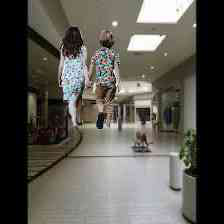

In [0]:
a

In [0]:
cd '/content/gdrive/My Drive/'

/content/gdrive/My Drive


# Creating directory to store Depth Images

In [0]:
!mkdir DepthPart5

In [0]:
ls

'Colab Notebooks'/    DepthPart4/  'Hospital reports.pdf'
 DepthPart1/          DepthPart5/  'Nia Call Letter.pdf'
 DepthPart_1_80K      Depth_Set/
 DepthPart_240_320K   EVA4/


In [0]:
%cd '/content/DepthModel/'

/content/DepthModel


# Modules for Depth Model to predict Depth Images

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import notebook

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(path,start,end):
    loaded_images = []
    for i in range(start,end):
        x = np.clip(np.asarray(Image.open(f"{path}bgfg{str(i)}.jpg" ).resize((448,448)), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True, start = 1):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('gray')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    print(shape)
    
    #all_images = []
    start = start
    for i in notebook.tqdm(range(outputs.shape[0]),desc = f"Loading from {start} images") :
    
        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
  
            #plt.figure(figsize=(2.24,2.24),dpi=100)
            matplotlib_image = plt.imshow(plasma(rescaled)[:,:,:3])
            pil_image = Image.fromarray(np.uint8( ( matplotlib_image.get_array()*255))).convert("L").resize((224,224))
            pil_image.save(f"/content/gdrive/My Drive/DepthPart5/depth{str(start)}.jpg")
            plt.close() 
            start+=1

            # plt.imsave("a.jpg",plasma(rescaled)[:,:,:3])          

        
           

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e
   
           

# Creating Depthmaps into sets for one dataset

In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 320001 
for  i in range((323200-320000)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")
 

Using TensorFlow backend.


Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 323201 
for  i in range((326400-323200)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 326401 
for  i in range((329600-326400)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 329601 
for  i in range((332800-329600)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 332801 
for  i in range((336000-332800)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 336001 
for  i in range((339200-336000)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 339201 
for  i in range((342400-339200)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 342401 
for  i in range((345600-342400)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 345601 
for  i in range((348800-345600)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 348801 
for  i in range((352000-348800)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 352001 
for  i in range((355200-352000)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 355201 
for  i in range((358400-355200)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 358401 
for  i in range((361600-358400)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 361601 
for  i in range((364800-361600)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 364801 
for  i in range((368000-364800)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 368001 
for  i in range((371200-368000)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 371201 
for  i in range((374400-371200)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 374401 
for  i in range((377600-374400)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 377601 
for  i in range((380800-377600)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 380801 
for  i in range((384000-380800)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 384001 
for  i in range((387200-384000)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 387201 
for  i in range((390400-387200)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 390401 
for  i in range((393600-390400)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 393601 
for  i in range((396800-393600)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 396801 
for  i in range((400000-396800)//div): 

  
  inputs = load_images(path ="/content/OverlayDir_Sample5/BgFg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [0]:
!ls '/content/gdrive/My Drive/'

'Colab Notebooks'     DepthPart4  'Hospital reports.pdf'
 DepthPart1	      DepthPart5  'Nia Call Letter.pdf'
 DepthPart_1_80K      Depth_Set
 DepthPart_240_320K   EVA4


In [0]:
!ls '/content/gdrive/My Drive/DepthPart5/' | wc -l

80000


In [0]:
!ls /content/

DepthModel  gdrive  OverlayDir_Sample5	sample_data


In [0]:
!pwd

/content/DepthModel


# Storing and Zipping the folder of Depth Images

In [0]:
from zipfile import ZipFile 
import os 
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = '/content/gdrive/My Drive/DepthPart5'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    print('Following files will be zipped:') 
    for file_name in file_paths: 
        print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('/content/gdrive/My Drive/DepthPart_320_400K','a') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')         
  
  

main()

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/DepthPart5/depth395003.jpg
/content/gdrive/My Drive/DepthPart5/depth395004.jpg
/content/gdrive/My Drive/DepthPart5/depth395005.jpg
/content/gdrive/My Drive/DepthPart5/depth395006.jpg
/content/gdrive/My Drive/DepthPart5/depth395007.jpg
/content/gdrive/My Drive/DepthPart5/depth395008.jpg
/content/gdrive/My Drive/DepthPart5/depth395009.jpg
/content/gdrive/My Drive/DepthPart5/depth395010.jpg
/content/gdrive/My Drive/DepthPart5/depth395011.jpg
/content/gdrive/My Drive/DepthPart5/depth395012.jpg
/content/gdrive/My Drive/DepthPart5/depth395013.jpg
/content/gdrive/My Drive/DepthPart5/depth395014.jpg
/content/gdrive/My Drive/DepthPart5/depth395015.jpg
/content/gdrive/My Drive/DepthPart5/depth395016.jpg
/content/gdrive/My Drive/DepthPart5/depth395017.jpg
/content/gdrive/My Drive/DepthPart5/depth395018.jpg
/content/gdrive/My Drive/DepthPart5/depth395019.jpg
/content/gdrive/My Drive/DepthPart5/depth395020.jpg
/content/gdri

# Background -  Foreground Image

In [0]:
from PIL import Image
a = Image.open("/content/OverlayDir_Sample5/BgFg/bgfg340500.jpg")

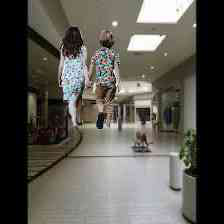

In [0]:
a

# Corresponding Depth Image

In [0]:
from PIL import Image
b = Image.open("/content/gdrive/My Drive/DepthPart5/depth340500.jpg")

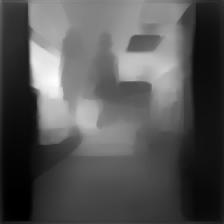

In [0]:
b

Submitted by G Uday Kiran and Srilakshmi V